# Import Libraries

In [662]:
import time
import os
# Simple file path extractor
import glob

# Matrice Operations
import numpy as np
# Image Processing
import cv2

# Visualizing Images
import matplotlib.pyplot as plt
# Visualizing 3D Plots
from mpl_toolkits.mplot3d import Axes3D
# Display plots in notebook
%matplotlib inline

# Hog Features Extractor
from skimage.feature import hog
# Data Normalization
from sklearn.preprocessing import StandardScaler
# Data Split
from sklearn.cross_validation import train_test_split
# Linear SVM
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

# Will stick with cv2.imread() for scaling consistency
# import matplotlib.image as mpimg

# Tools Investigation

Experimenting with each of the components that can be used in the vehicle detection pipeline.

## Reading Images

In [344]:
def imread(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

## Drawing Boxes

Prepare a method to draw boxes around detected cars. Define a function that takes an image, a list of bounding boxes, 
and optional color tuple and line thickness as inputs then draws boxes in that color on the output:

In [486]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

Test boxes drawing

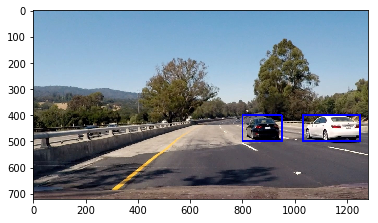

In [487]:
image = imread('test_images/test4.jpg')

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((800, 400), (950, 500)), ((1030, 400), (1250, 500))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

plt.imsave("output_images/drawing_boxes.png", result)

## Histograms of Color

The following function computes histogram for each colour channel of an image:

In [488]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # If you want to return just the hist_features
#    return hist_features
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges) - 1]) / 2
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Test color histograms:

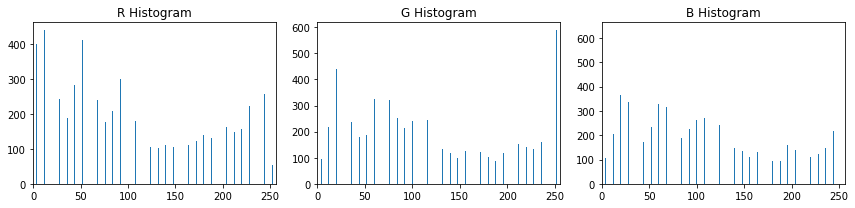

In [489]:
image = imread('test_images/cutout1.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## Exploring Colour Spaces

The following function can be used to explore the distribution of colour channels in an image:

In [490]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

Check distribution:

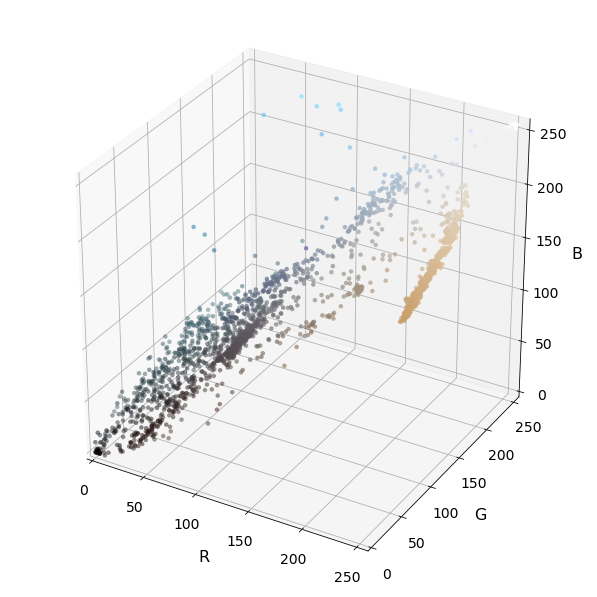

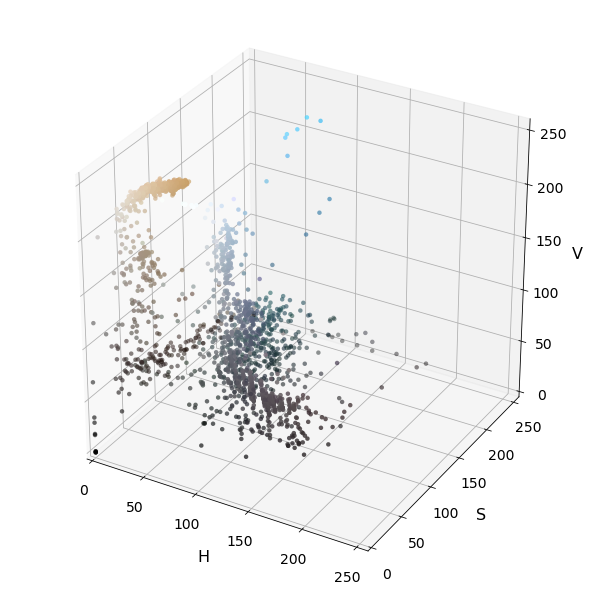

In [491]:
# Read a color image
img = imread('test_images/test4.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## Spatial Binning of Color
Histograms of raw pixel values can be used as features for image recognition:

In [492]:
# Function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    else:
        feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

Testing function:

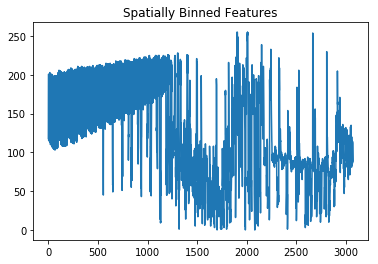

In [494]:
# Read a color image
image = imread('test_images/test4.jpg')

feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## HOG Features

Extract Histogram of Oriented Gradient features. They are capable of better retaining the uniqueness of the data while also leaving space for variations that account for different representations of the same object:

In [353]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

/Users/william.oanta/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


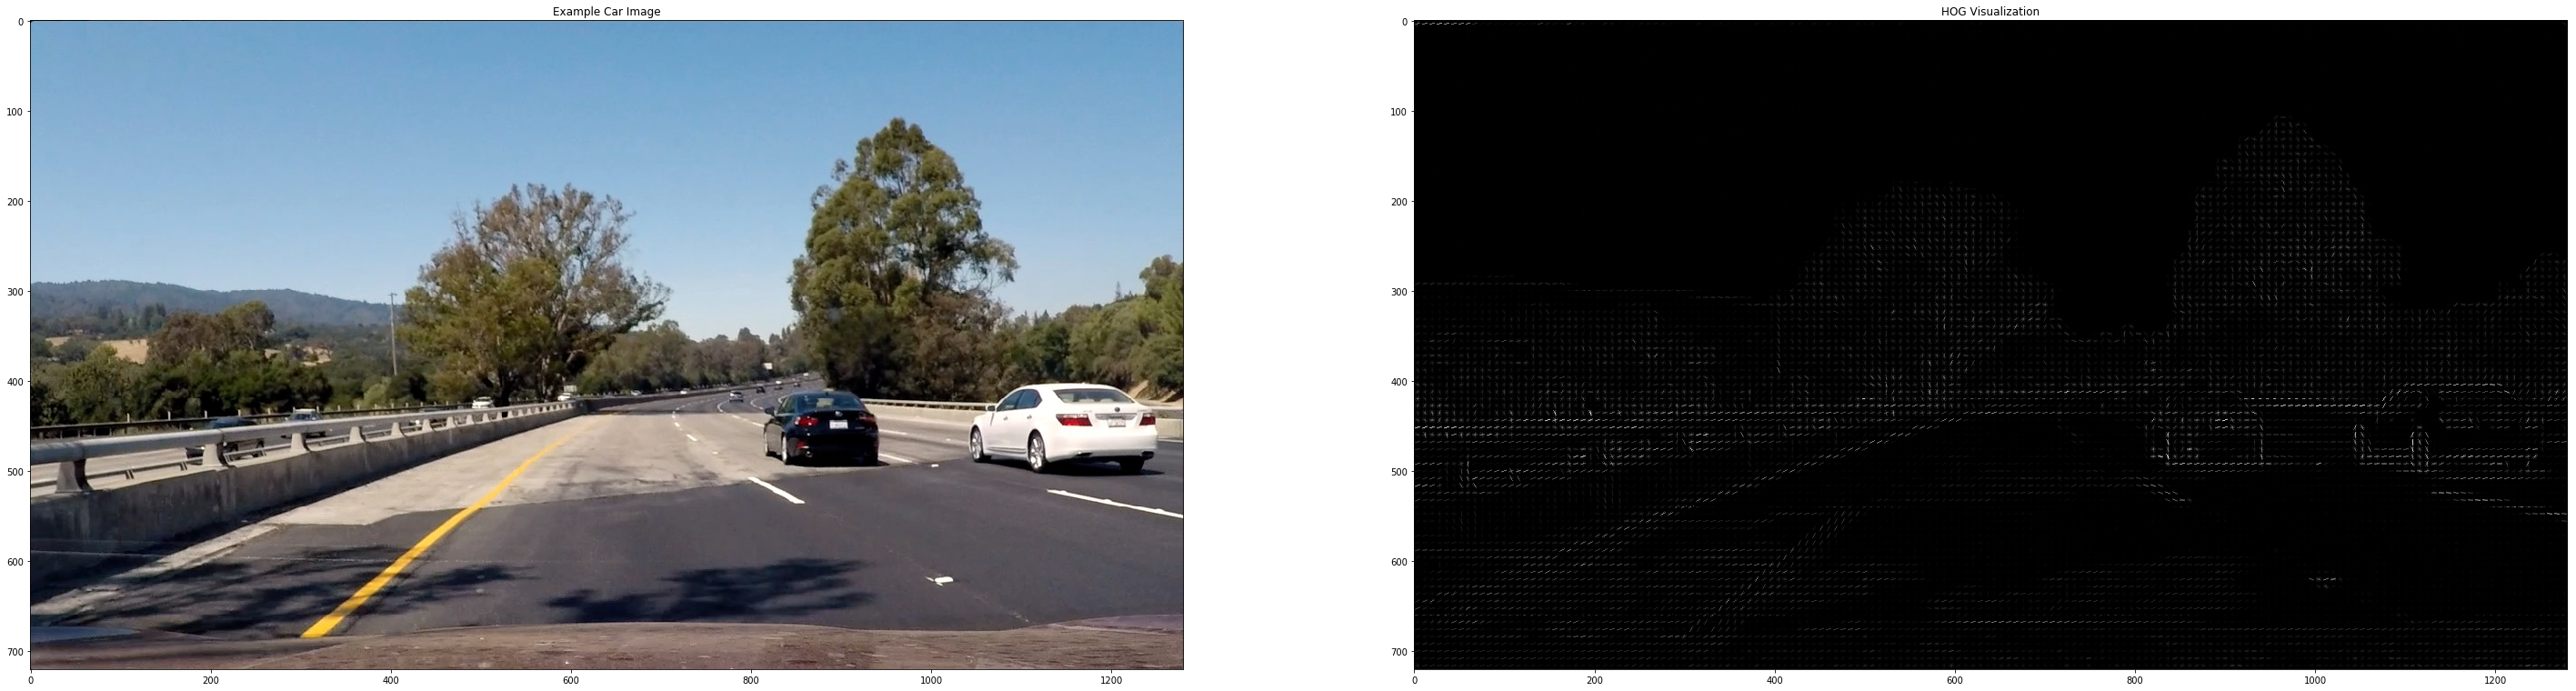

In [495]:
# Read in the image
image = imread('test_images/test4.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(50, 40))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.imsave("output_images/feature_vec.png", hog_image)

## Feature Extraction

Function to extract features from a list of images, using all of the above histogram methods defined:

In [496]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        # Read in each one by one
        image = imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)      
                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

## Sliding Window

Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y), and returns a windows list 

In [497]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

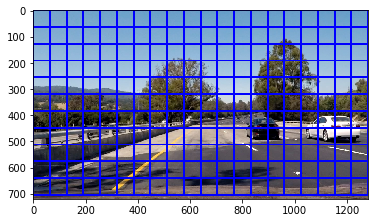

In [499]:
image = imread('test_images/test4.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.imsave("output_images/sliding_windows.png", window_img)

# Vehicle Detection

Build the Vehicle Detection Pipeline

## Prepare Dataset

First we will prepare the dataset for training


### Load Image Paths

In [377]:
from os import listdir
from os.path import isfile, join

# Data directories names
data_folder = "data"
cars_folder = "vehicles"
notcars_folder = "non-vehicles"

# Load Cars Images
car_paths = "{}/{}/*/*.png".format(data_folder, cars_folder)
cars = glob.glob(car_paths)
print(len(cars))
    
# Load NonCar Images
notcar_paths = "{}/{}/*/*.png".format(data_folder, notcars_folder)
notcars = glob.glob(notcar_paths)
print(len(notcars))

8792
8968


### Dataset characteristic functions:

Define a function that computes dataset characteristics:

In [378]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Check dataset characteristics:

There are 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


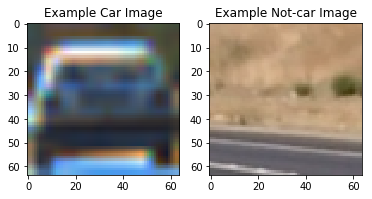

In [379]:
data_info = data_look(car_list, notcar_list)

print('There are', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Plot one random example for each class
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = imread(cars[car_ind])
notcar_image = imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Extract Features

Try out hog feature on an image from each class from the dataset:

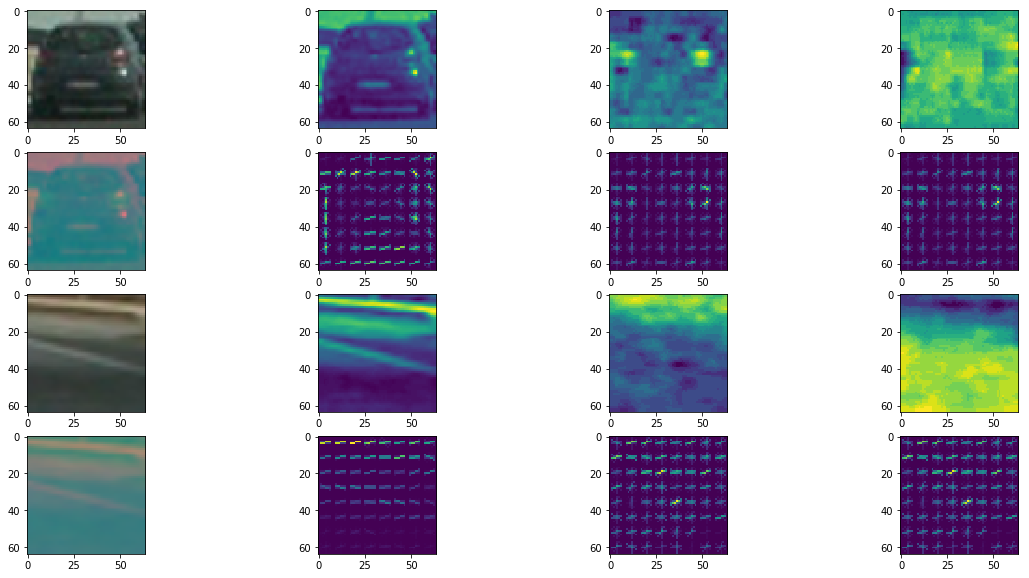

In [721]:
# Plot one random example for each class
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = imread(cars[car_ind])
notcar_image = imread(notcars[notcar_ind])

# Convert Images to YCrCb Space
ycrcb_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
ycrcb_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

# Extract Colour Channels
car_ch1 = ycrcb_car_image[:,:,0]
car_ch2 = ycrcb_car_image[:,:,1]
car_ch3 = ycrcb_car_image[:,:,2]

notcar_ch1 = ycrcb_notcar_image[:,:,0]
notcar_ch2 = ycrcb_notcar_image[:,:,1]
notcar_ch3 = ycrcb_notcar_image[:,:,2]

# Define HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2

_, car_ch1_img = get_hog_features(car_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, car_ch2_img = get_hog_features(car_ch2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, car_ch3_img = get_hog_features(car_ch3, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch1_img = get_hog_features(notcar_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch2_img = get_hog_features(notcar_ch2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch3_img = get_hog_features(notcar_ch3, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

    
# Plot Results
f, axs = plt.subplots(4, 4, figsize=(20, 10))

# Original Image with YCrCb Channels
axs[0][0].imshow(car_image)
axs[0][1].imshow(car_ch1)
axs[0][2].imshow(car_ch2)
axs[0][3].imshow(car_ch3)

# YCrCb Image with Channel Gradients
axs[1][0].imshow(ycrcb_car_image)
axs[1][1].imshow(car_ch1_img)
axs[1][2].imshow(car_ch2_img)
axs[1][3].imshow(car_ch2_img)

# Original Image with YCrCb Channels

axs[2][0].imshow(notcar_image)
axs[2][1].imshow(notcar_ch1)
axs[2][2].imshow(notcar_ch2)
axs[2][3].imshow(notcar_ch3)

# YCrCb Image with Channel Gradients
axs[3][0].imshow(ycrcb_notcar_image)
axs[3][1].imshow(notcar_ch1_img)
axs[3][2].imshow(notcar_ch2_img)
axs[3][3].imshow(notcar_ch2_img)

plt.imsave("output_images/car_ch1_img.png", car_ch1_img)
plt.imsave("output_images/car_ch2_img.png", car_ch2_img)
plt.imsave("output_images/car_ch3_img.png", car_ch3_img)

plt.imsave("output_images/notcar_ch1_img.png", notcar_ch1_img)
plt.imsave("output_images/notcar_ch2_img.png", notcar_ch2_img)
plt.imsave("output_images/notcar_ch3_img.png", notcar_ch3_img)

Redefine the extraction functions, modified for the pipeline:

In [380]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#### HOG Features
Extract only hog features for training

In [628]:
### Feacture Extraction Parmeters

hog_feat = True # HOG features on or off
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions

hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

### Normalize Data

In [629]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### Define Labels

In [630]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Split data into training and testing

In [709]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468


## Traing Model

Train the model that we will use for detections

In [632]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

16.07 Seconds to train SVC...


Test Accuracy

In [633]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9882


### Using Grid Search for Parameters Tunning

Tune the hyperparameters using grid search:

In [160]:
from sklearn.grid_search import GridSearchCV
parameters = {'loss':('hinge', 'squared_hinge'), 'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 'C':[0.5, 1, 1.5, 2]}
svm_linear = LinearSVC()
clf = GridSearchCV(svm_linear, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1, 1.5, 2], 'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06], 'loss': ('hinge', 'squared_hinge')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Check best params:

Print best params:

In [164]:
clf.best_params_

{'C': 1, 'loss': 'squared_hinge', 'tol': 0.1}

Check accuracy with this configuration:

In [167]:
# Use a linear SVC 
optim_svc = LinearSVC(C=1, loss='squared_hinge', tol=0.1)
# Check the training time for the SVC
t=time.time()
optim_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(optim_svc.score(X_test, y_test), 4))

4.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9662


## Sliding Window Search

Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y), and returns a list of windows:

In [634]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

Define a function to extract features from a single image. This function is very similar to extract_features(), but it just extracts features for a single image rather than a list of images.

In [635]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    # 1) Define an empty list to receive features
    img_features = []
    
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
        
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

Define a function you will pass an image and the list of windows to be searched (output of slide_windows())

In [636]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    
    # 2) Iterate over all windows in the list
    for window in windows:
        
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

## Test Classifier on Image

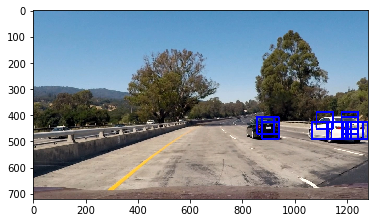

In [723]:
# Check the prediction time for a single sample
t=time.time()

image = imread('test_images/test1.jpg')
draw_image = np.copy(image)

small_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))

medium_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 600], 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))

large_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500, None], 
                    xy_window=(256, 256), xy_overlap=(0.7, 0.7))

windows = small_windows + medium_windows + large_windows

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.imsave("output_images/testing_classifier_1.png", window_img)

## HOG Sub-sampling Window search

Function that can extract features using hog sub-sampling and makes predictions

In [740]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, color_space='YCrCb'):
    
    feature_image = np.copy(img)
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return feature_image


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, draw_on_image=True):
    
    if draw_on_image:
        draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop, :, :]
    
    # Apply Conversion
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    
    # Rescale Image 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Extract Colour Channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Array to store boxes
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))   
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # Append Box
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                # Flag for speeding processing on video
                if draw_on_image:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart), (0,0,255),6) 
    
    if draw_on_image:
        return bboxes, draw_img
    else:
        return bboxes

Test It

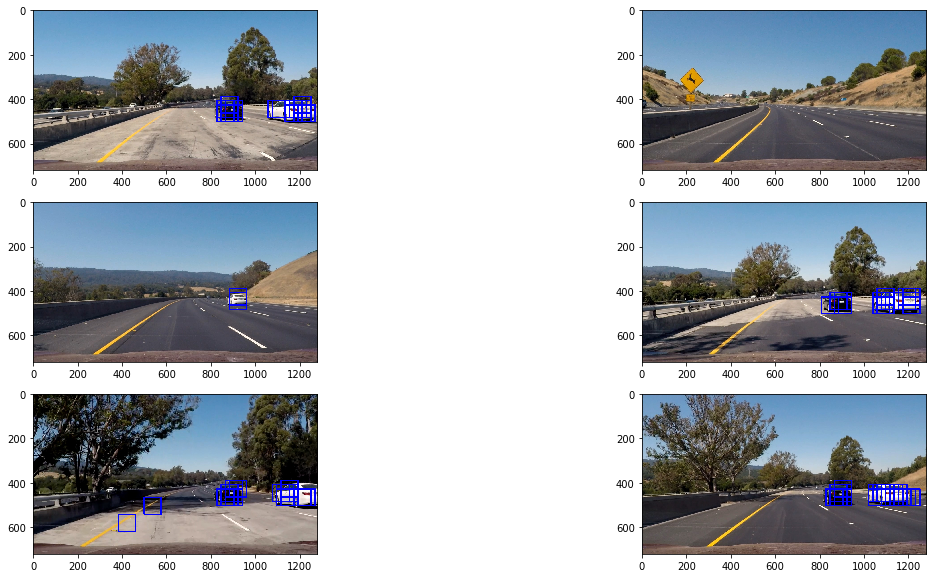

In [741]:
# Get Test Images Path
test_images = glob.glob('test_images/*.jpg')

# Tune Params
ystart = 350
ystop = 656
scale = 1.2
cell_per_block = 2
pix_per_cell = 8
orient = 11

f, axs = plt.subplots(3, 2, figsize=(20, 10))
axs = axs.ravel()

i = 0

# Process all Images
for img in test_images:
    # Read Image
    tst_img = imread(img)
    
    # Find Cars
    boxes, out_img = find_cars(tst_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    # Display Boxes
    axs[i].imshow(out_img)
    
    # Get Image Name
    image_name = os.path.basename(img)
    
    # Save Image
    plt.imsave("output_images/{}-predicted.png".format(image_name[:-4]), out_img)
    
    i += 1
    
plt.show()

## Multiple Detections & False Positives

Create a heat-map from detections in order to combine overlapping detections and remove false positives.

Add heat (+1) for all pixesl within boxes:

In [742]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Imposing a threshold to reject areas affected by false positives:

In [743]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Function to draw bounding boxes around the labeled regions:

In [744]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

Test It on above Image

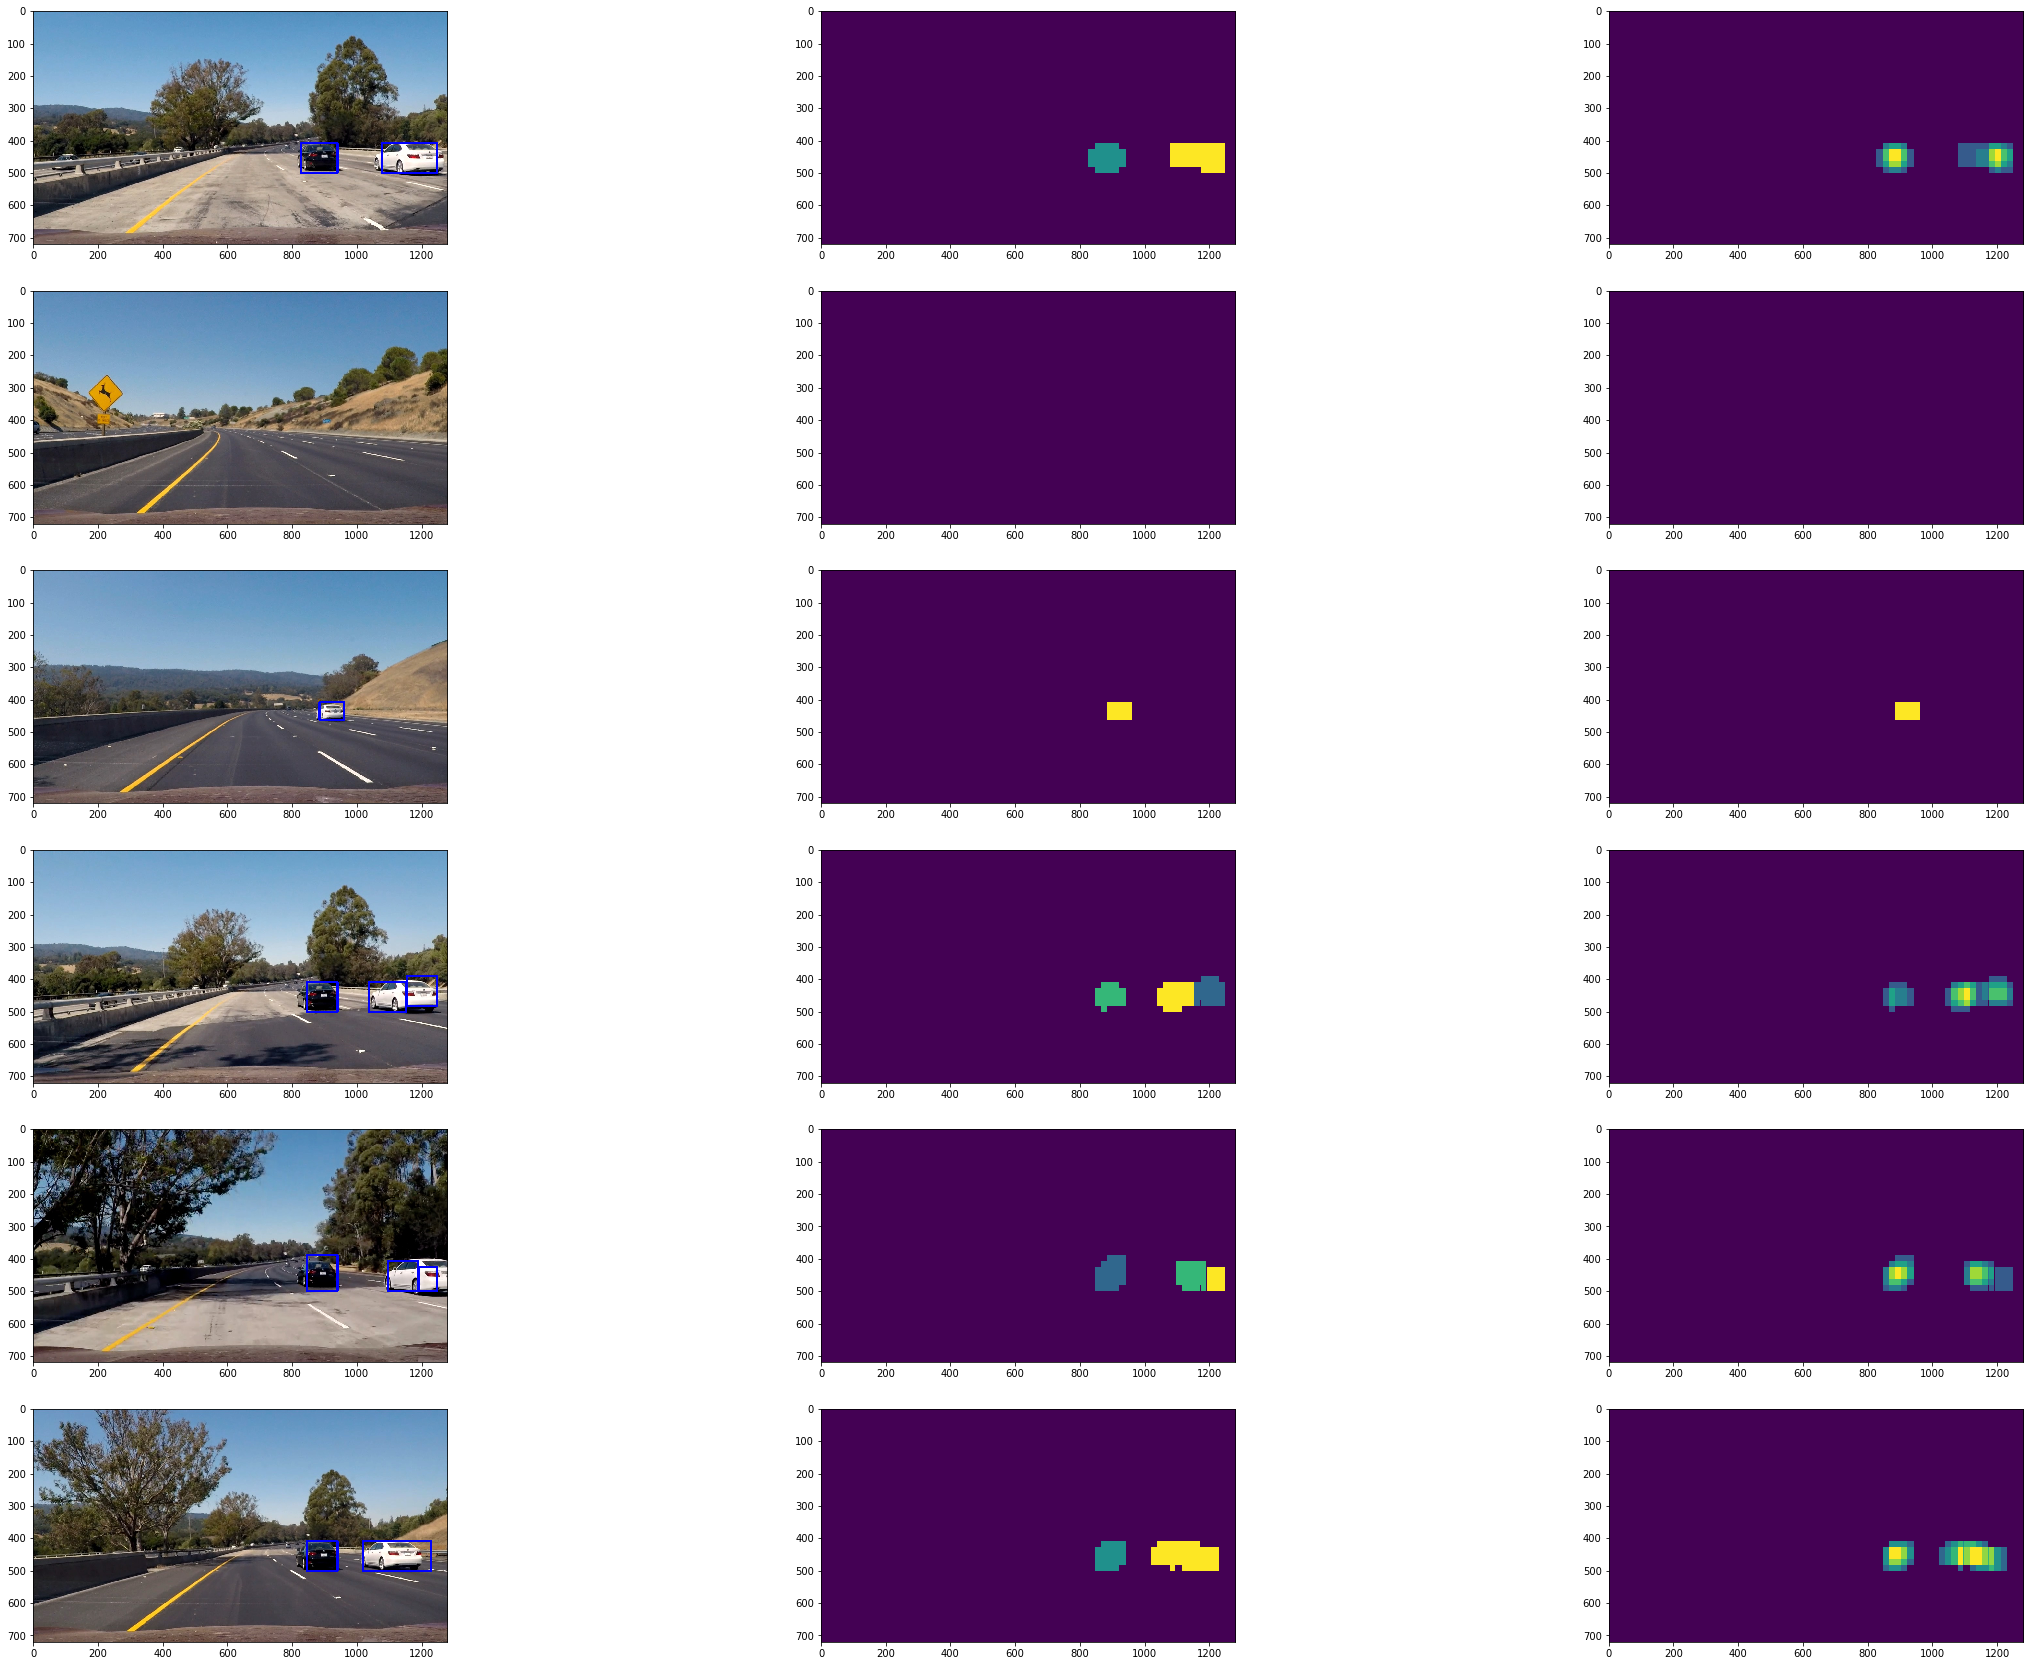

In [760]:
f, axs = plt.subplots(6, 3, figsize=(40, 30))
axs = axs.ravel()

i = 0

# Process all Images
for img in test_images:
    # Read Image
    tst_img = imread(img)
    
    # Find Cars
    box_list, out_img = find_cars(tst_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
   
        # Prepare heat map
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(tst_img), labels)

    # Display Boxes
    axs[i].imshow(draw_img)
        
    # Display Labels
    axs[i + 1].imshow(labels[0])

    # Display Heatmap
    axs[i + 2].imshow(heatmap)
    
    i += 3
    
plt.show()

Put them all together in a single noise filter function:

In [761]:
def filter_noise(box_lists, heat, thresh=1):
    
    boxes = []
    for box_list in box_lists: 
        boxes = boxes + box_list
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return labels, heatmap

Integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool".


## Vehicle Detection Pipeline:

Now we can put everything together in a single vehicle detection pipeline:

In [775]:
# Tune Params
ystart = 350
ystop = 656
scale = 1.2
cell_per_block = 2
pix_per_cell = 8
orient = 11

class Counter():
    def __init__(self, n, thresh):
        self.MAX = n
        self.box_list = []
        self.thresh = thresh
        
def pipeline(img):
    
    image = np.copy(img)
    current_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, draw_on_image=False)
    
    if len(counter.box_list) > counter.MAX:
        # FIFO stack of boxes
        counter.box_list = counter.box_list[1:]

    counter.box_list.append(current_boxes)
        
   # Prepare heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    labels, heatmap = filter_noise(counter.box_list, heat, thresh=counter.thresh)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

## Test on Videos

In [763]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Test Video

In [792]:
counter = Counter(2, 1)

test_output = 'output_videos/test_video_output.mp4'

test_clip = VideoFileClip("test_video.mp4")
processed_test_clip = test_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video_output.mp4
[MoviePy] Writing video output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video_output.mp4 

CPU times: user 17.4 s, sys: 859 ms, total: 18.2 s
Wall time: 19.3 s


In [794]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output)) 

### Project Video

In [767]:
counter = Counter(2, 1)

project_output = 'output_videos/project_video_output.mp4'

project_clip = VideoFileClip("project_video.mp4")
processed_project_clip = project_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [08:38<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 8min 27s, sys: 16.9 s, total: 8min 44s
Wall time: 8min 38s


In [768]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output)) 

In [795]:
counter = Counter(4, 3)

project_output_2 = 'output_videos/project_video_output_2.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_clip_2 = VideoFileClip("project_video.mp4").subclip(0,10)
processed_project_clip_2 = project_clip_2.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_project_clip_2.write_videofile(project_output_2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output_2.mp4
[MoviePy] Writing video output_videos/project_video_output_2.mp4


100%|█████████▉| 250/251 [01:52<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output_2.mp4 

CPU times: user 1min 47s, sys: 4.45 s, total: 1min 52s
Wall time: 1min 53s


In [796]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_2)) 

# My Video

In [790]:
counter = Counter(4, 2)

my_video = 'output_videos/my_video_output.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
my_clip = VideoFileClip("my_video.mov")
processed_my_clip = my_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_my_clip.write_videofile(my_video, audio=False)

[MoviePy] >>>> Building video output_videos/my_video_output.mp4
[MoviePy] Writing video output_videos/my_video_output.mp4


100%|██████████| 3095/3095 [28:52<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/my_video_output.mp4 

CPU times: user 27min 19s, sys: 1min 43s, total: 29min 3s
Wall time: 28min 52s


In [791]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(my_video)) 